<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/advanced-ppg-clustering-peak-to-peak-aug-data/blob/main/pca_150000_autoEncoder_12Bottelneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#to read csv files
import pandas as pd 

#to manipulate data
import numpy as np

#for ploting
import matplotlib.pyplot as plt
import seaborn as sns

#for LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#for PCA
from sklearn.decomposition import PCA

#for Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#for auto-encoder
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [ ]:
ppg_one_beat = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_PPG_beats_P2P_Aug_2022.csv",
                           names = np.arange(120))
ppg_10_beats = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_PPG_signals_10_beats_Aug_2022.csv",
                           names = np.arange(1024))
id = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_Subj_ID_beats_P2P_Aug_2022.csv",names = ["ID"])
sys_df = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_SYS_BP_beats_P2P_Aug_2022.csv",
                     names = ["sys"])
dia_df = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_Dia_BP_beats_P2P_Aug_2022.csv",
                     names = ["dia"])

In [ ]:
df_info = pd.DataFrame()
 
df_info["dia"]  = dia_df
df_info["sys"]  = sys_df
df_info["ID"] = id

In [ ]:
X = ppg_one_beat.values

In [ ]:
pca = PCA(n_components=5) 
pca.fit(X)
PCA_values = pca.transform(X)

Text(0.5, 1.0, '‘Silhouette analysis For Optimal k’')

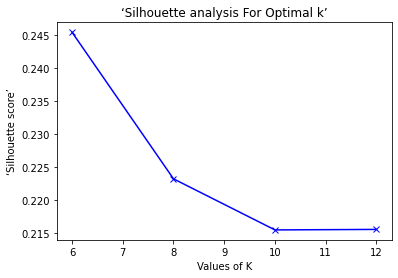

In [ ]:
range_n_clusters = [ 6,8,10,12]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(PCA_values)
  cluster_labels = kmeans.labels_
  
  # silhouette score
  silhouette_avg.append(silhouette_score(PCA_values, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel('Values of K') 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")

In [ ]:
# initialise kmeans

kmeans = KMeans( n_clusters = 6 )

kmeans.fit( PCA_values )

PCA_cluster_labels = kmeans.labels_


In [ ]:
df_info["PCA_cluster_labels"] = PCA_cluster_labels

In [ ]:
df_info

,dia,sys,ID,PCA_cluster_labels
0,66.526,123.040,1,1
1,65.598,120.990,1,1
2,66.135,119.570,1,5
3,66.135,122.350,1,5
4,67.503,122.750,1,1
...,...,...,...,...
154535,58.357,88.240,3000,3
154536,58.983,88.240,3000,3
154537,58.670,86.988,3000,3
154538,58.044,88.866,3000,3


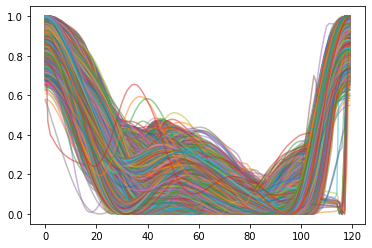

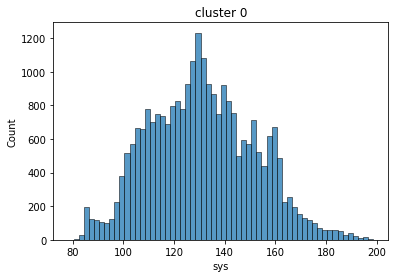

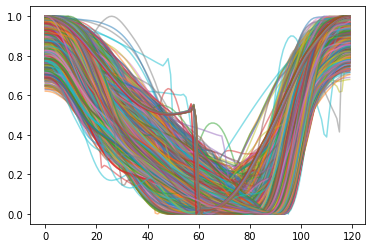

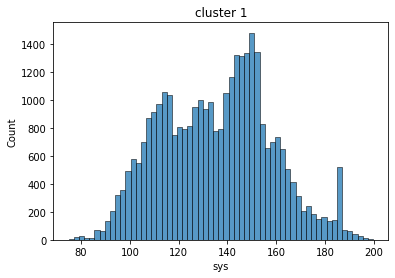

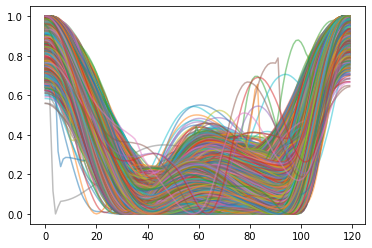

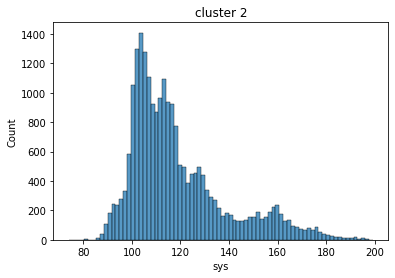

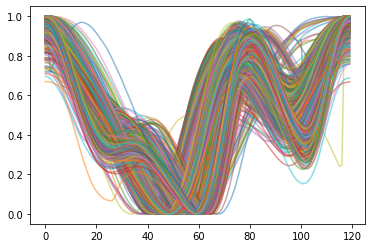

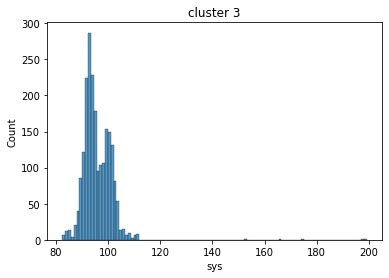

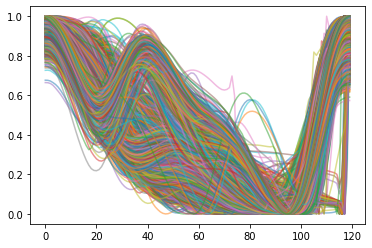

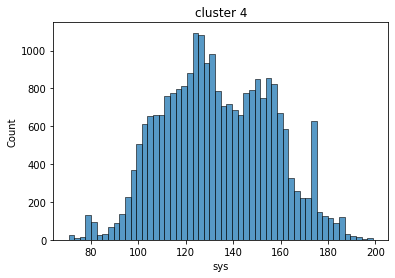

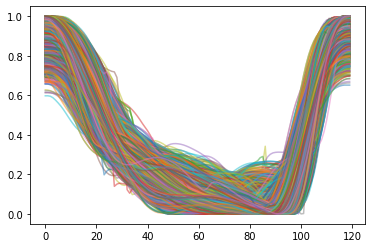

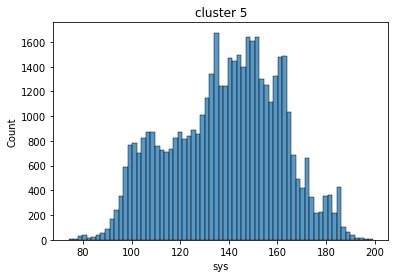

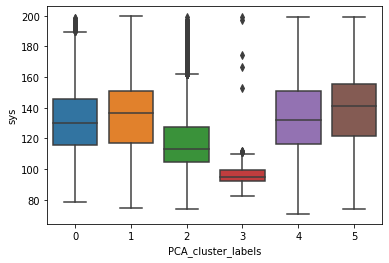

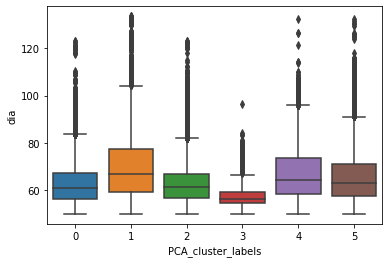

In [ ]:
for i in range(6):
  plt.figure();
  plt.plot(ppg_one_beat[PCA_cluster_labels == i].values[:].T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x =  df_info["sys"][df_info ["PCA_cluster_labels"] == i]  )

plt.figure();
sns.boxplot(x = "PCA_cluster_labels",y="sys",data = df_info)
plt.figure();
sns.boxplot(x = "PCA_cluster_labels",y="dia",data = df_info)

# autoencoder

In [ ]:
X_train = X[:115905,:]
X_test = X[115905:,:]

In [ ]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs/2)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 3
encoder= Dense(round(float(n_inputs) / 4))(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 10)
bottleneck = Dense(n_bottleneck)(encoder)


# define decoder, level 1
decoder = Dense(round(float(n_inputs) / 4.0))(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs/2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 3
decoder = Dense(n_inputs)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [ ]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense_8 (Dense)             (None, 120)               14520     
                                                                 
 batch_normalization_6 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 60)                7260      
                                                                 
 batch_normalization_7 (Batc  (None, 60)               240       
 hNormalization)                                           

In [ ]:
history = model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/50
7245/7245 - 26s - loss: 4.5689e-04 - val_loss: 3.0149e-04 - 26s/epoch - 4ms/step
Epoch 2/50
7245/7245 - 27s - loss: 4.3204e-04 - val_loss: 3.7144e-04 - 27s/epoch - 4ms/step
Epoch 3/50
7245/7245 - 24s - loss: 4.1701e-04 - val_loss: 2.8895e-04 - 24s/epoch - 3ms/step
Epoch 4/50
7245/7245 - 26s - loss: 4.0505e-04 - val_loss: 3.0048e-04 - 26s/epoch - 4ms/step
Epoch 5/50
7245/7245 - 26s - loss: 3.9923e-04 - val_loss: 2.6207e-04 - 26s/epoch - 4ms/step
Epoch 6/50
7245/7245 - 24s - loss: 3.8539e-04 - val_loss: 2.3052e-04 - 24s/epoch - 3ms/step
Epoch 7/50
7245/7245 - 27s - loss: 3.8077e-04 - val_loss: 2.7270e-04 - 27s/epoch - 4ms/step
Epoch 8/50
7245/7245 - 25s - loss: 3.6862e-04 - val_loss: 2.7367e-04 - 25s/epoch - 3ms/step
Epoch 9/50
7245/7245 - 25s - loss: 3.6528e-04 - val_loss: 2.3715e-04 - 25s/epoch - 3ms/step
Epoch 10/50
7245/7245 - 23s - loss: 3.6598e-04 - val_loss: 2.1675e-04 - 23s/epoch - 3ms/step
Epoch 11/50
7245/7245 - 25s - loss: 3.5034e-04 - val_loss: 2.5099e-04 - 25s/epo

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('/content/gdrive/MyDrive/data/encoder150000beat_ver2.h5')

In [ ]:
encoder = load_model('/content/gdrive/MyDrive/data/encoder150000beat_ver2.h5')
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense_8 (Dense)             (None, 120)               14520     
                                                                 
 batch_normalization_6 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 60)                7260      
                                                                 
 batch_normalization_7 (Batc  (None, 60)               240       
 hNormalization)                                           

In [ ]:
X_encode = encoder.predict(X)

Text(0.5, 1.0, '‘Silhouette analysis For Optimal k’')

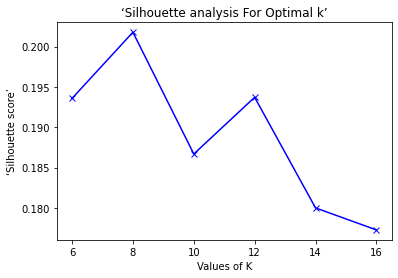

In [ ]:
# check best K for clustering 
range_n_clusters = [ 6,8,10,12,14,16]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_encode)
  cluster_labels = kmeans.labels_
  
  # silhouette score
  silhouette_avg.append(silhouette_score(X_encode, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel('Values of K') 
plt.ylabel("‘Silhouette score’") 
plt.title("‘Silhouette analysis For Optimal k’")

In [ ]:
# initialise kmeans
kmeans = KMeans(n_clusters=12)
kmeans.fit(X_encode)
encoder_cluster_labels = kmeans.labels_

In [ ]:
df_info ["encoder_cluster_labels"] = encoder_cluster_labels

In [ ]:
df_info

,dia,sys,ID,PCA_cluster_labels,encoder_cluster_labels
0,66.526,123.040,1,1,7
1,65.598,120.990,1,1,7
2,66.135,119.570,1,5,7
3,66.135,122.350,1,5,9
4,67.503,122.750,1,1,2
...,...,...,...,...,...
154535,58.357,88.240,3000,3,4
154536,58.983,88.240,3000,3,4
154537,58.670,86.988,3000,3,4
154538,58.044,88.866,3000,3,4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

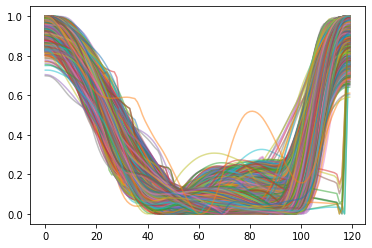

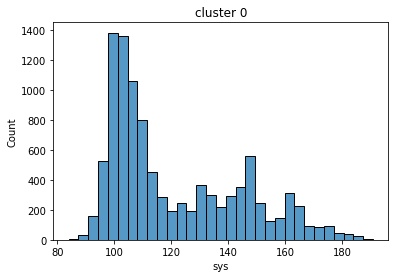

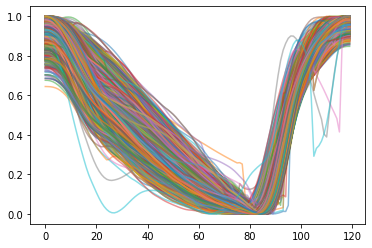

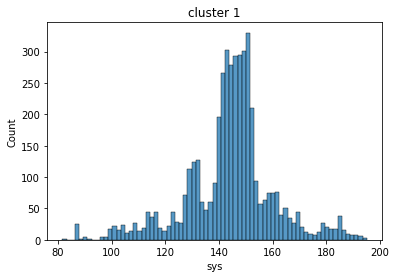

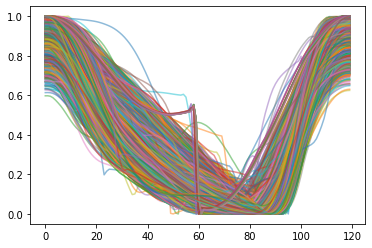

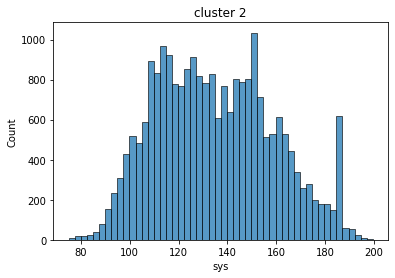

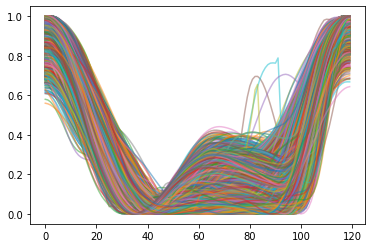

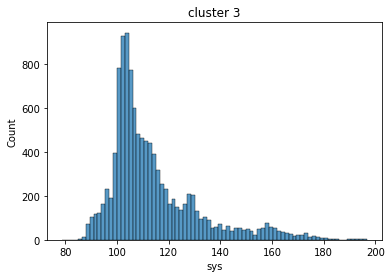

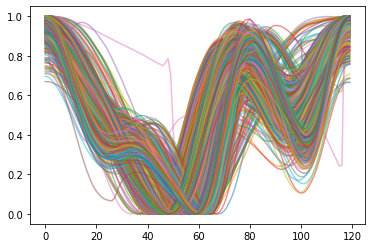

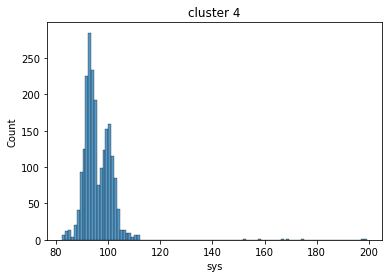

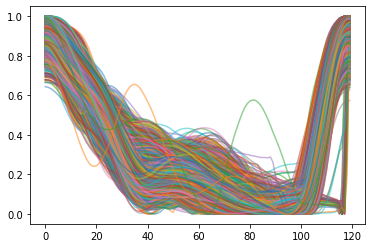

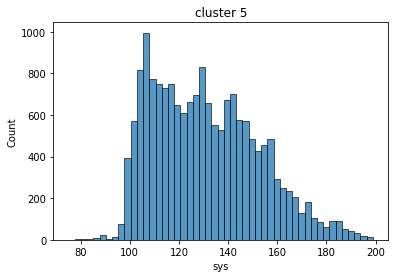

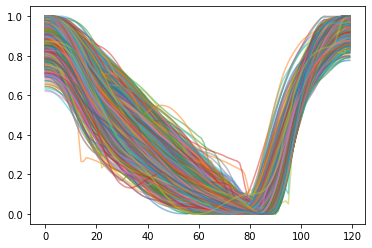

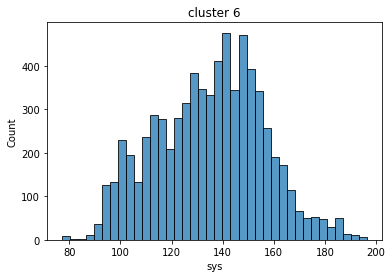

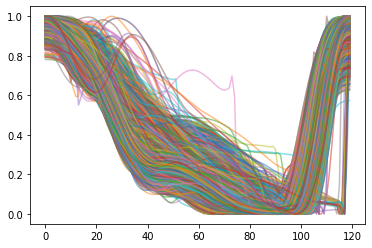

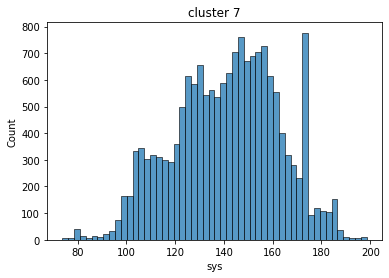

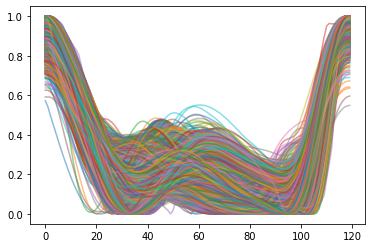

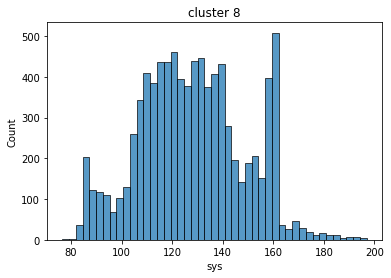

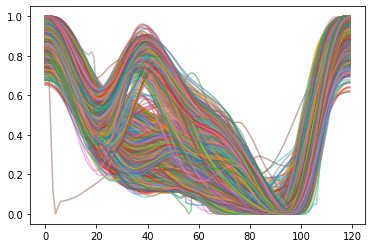

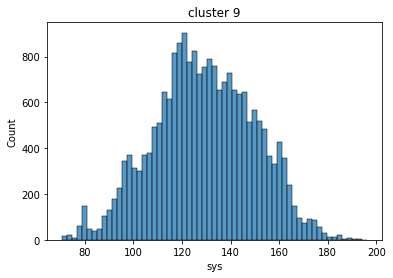

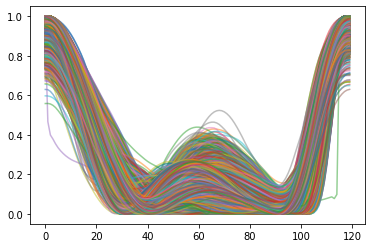

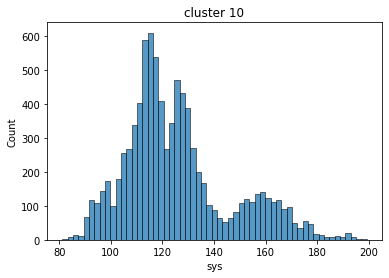

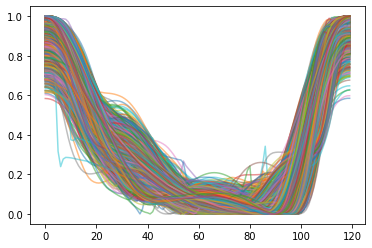

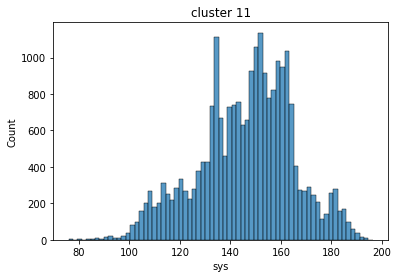

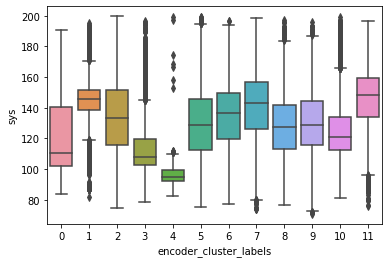

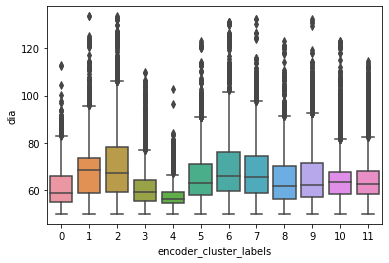

In [ ]:
for i in range(12):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info["sys"][df_info ["encoder_cluster_labels"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels",y="sys",data = df_info)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels",y="dia",data = df_info)

# cluster 9 sub-clustering

In [ ]:
X_train_9 = X[encoder_cluster_labels == 9,:]
X_train_9.shape

(21017, 120)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_9)
encoder_cluster_labels_9 = kmeans.labels_

In [ ]:
df_info_9 = df_info[df_info ["encoder_cluster_labels"] == 9]

In [ ]:
df_info_9["encoder_cluster_labels_9"] = encoder_cluster_labels_9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_info_9

,dia,sys,ID,PCA_cluster_labels,encoder_cluster_labels,encoder_cluster_labels_9
3,66.135,122.350,1,5,9,1
13,66.868,123.230,1,5,9,1
18,68.479,125.290,1,5,9,1
29,69.652,130.070,1,5,9,1
34,67.796,127.290,1,5,9,1
...,...,...,...,...,...,...
154235,70.091,95.124,2979,4,9,2
154236,70.091,92.777,2979,4,9,2
154237,69.935,92.464,2979,4,9,2
154238,69.778,92.777,2979,4,9,2


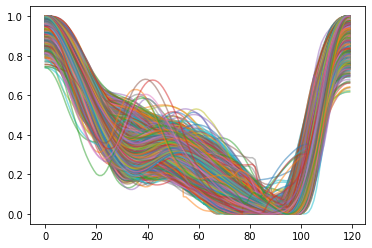

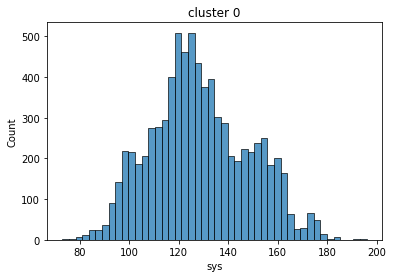

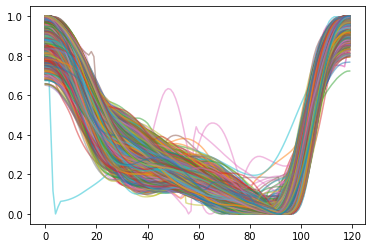

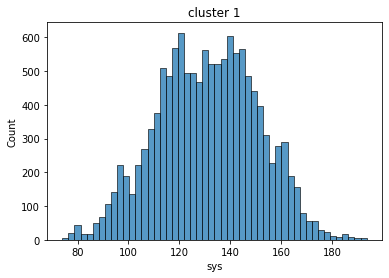

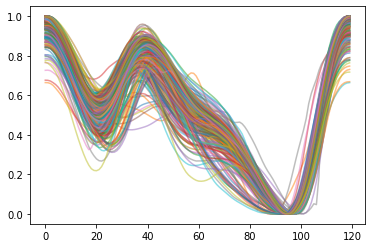

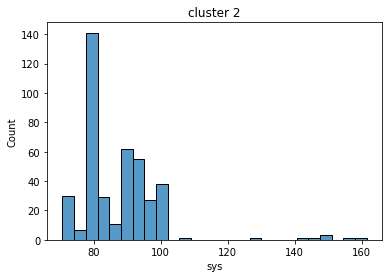

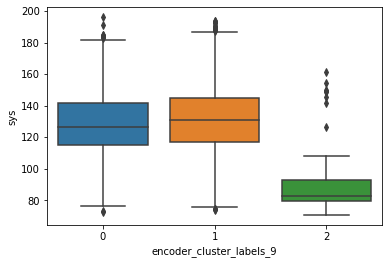

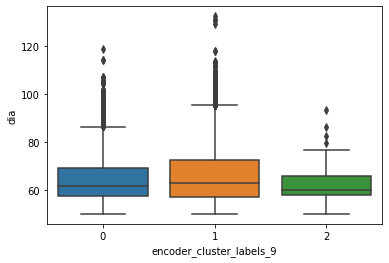

In [ ]:
for i in range(3):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == 9][encoder_cluster_labels_9 == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info_9["sys"][df_info_9 ["encoder_cluster_labels_9"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels_9",y="sys",data = df_info_9)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels_9",y="dia",data = df_info_9)

# cluster 5 sub-clustering

In [ ]:
X_train_5 = X[encoder_cluster_labels == 5,:]
X_train_5.shape

(17363, 120)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_5)
encoder_cluster_labels_5 = kmeans.labels_

In [ ]:
df_info_5 = df_info[df_info ["encoder_cluster_labels"] == 5]

In [ ]:
df_info_5["encoder_cluster_labels_5"] = encoder_cluster_labels_5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_info_5

,dia,sys,ID,PCA_cluster_labels,encoder_cluster_labels,encoder_cluster_labels_5
810,65.793,133.250,5,5,5,0
821,75.073,141.350,5,5,5,1
825,75.366,141.600,5,5,5,1
834,73.901,135.640,5,5,5,0
837,70.922,135.440,5,5,5,1
...,...,...,...,...,...,...
153698,73.999,145.800,2819,0,5,1
153699,74.438,146.530,2819,0,5,1
153739,72.875,134.320,2820,0,5,1
154088,58.357,88.396,2910,0,5,2


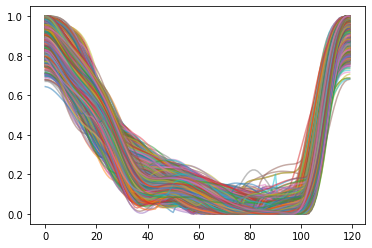

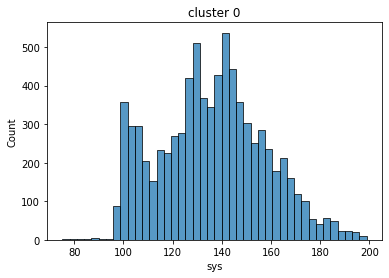

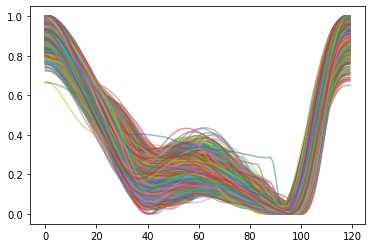

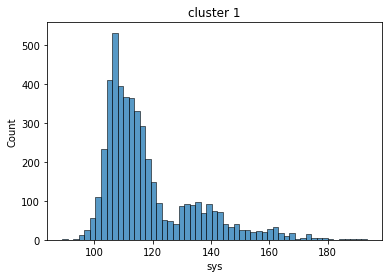

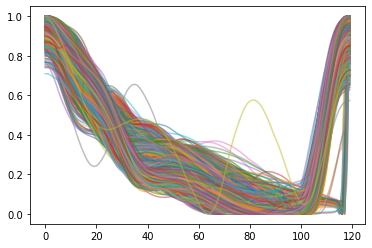

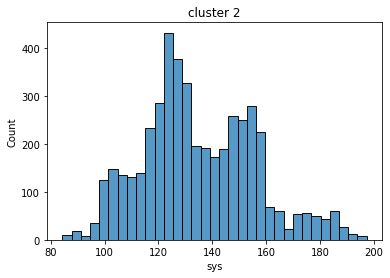

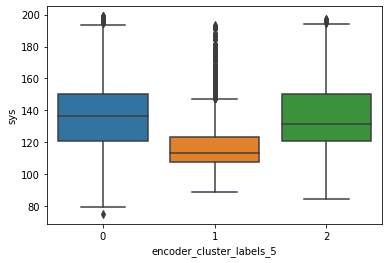

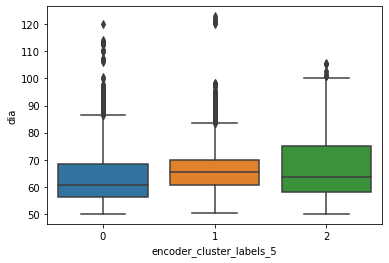

In [ ]:
for i in range(3):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == 5][encoder_cluster_labels_5 == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info_5["sys"][df_info_5 ["encoder_cluster_labels_5"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels_5",y="sys",data = df_info_5)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels_5",y="dia",data = df_info_5)

# cluster 2 sub-clustering

In [ ]:
X_train_2 = X[encoder_cluster_labels == 2,:]
X_train_2.shape

(23385, 120)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_2)
encoder_cluster_labels_2 = kmeans.labels_

In [ ]:
df_info_2 = df_info[df_info ["encoder_cluster_labels"] == 2]

In [ ]:
df_info_2["encoder_cluster_labels_2"] = encoder_cluster_labels_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_info_2

,dia,sys,ID,PCA_cluster_labels,encoder_cluster_labels,encoder_cluster_labels_2
4,67.503,122.75,1,1,2,1
8,68.284,125.19,1,1,2,1
9,69.114,125.19,1,1,2,1
10,67.112,123.62,1,5,2,1
14,67.747,123.38,1,1,2,1
...,...,...,...,...,...,...
153470,54.915,107.33,2813,5,2,1
153473,56.167,108.81,2813,5,2,1
153479,54.837,105.06,2813,5,2,1
153558,77.027,136.08,2818,5,2,2


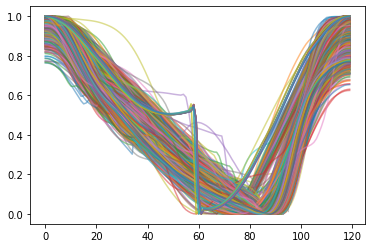

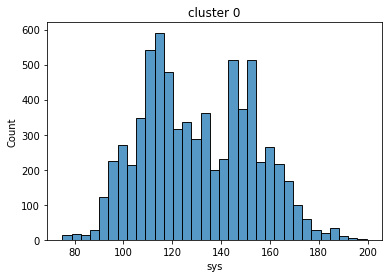

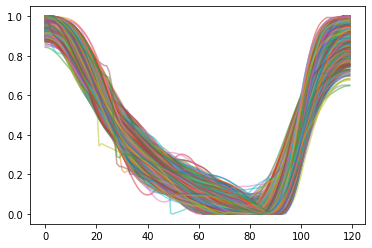

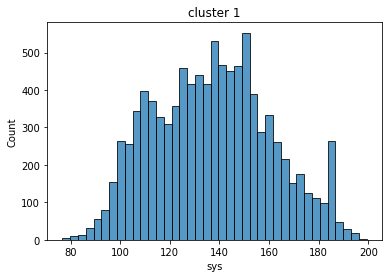

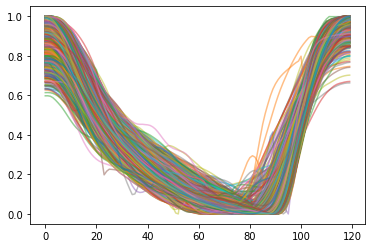

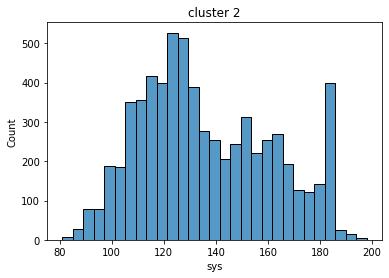

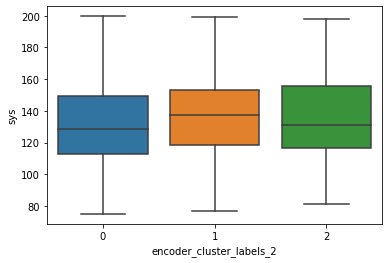

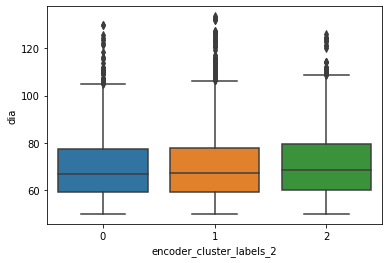

In [ ]:
for i in range(3):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == 2][encoder_cluster_labels_2 == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info_2["sys"][df_info_2 ["encoder_cluster_labels_2"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels_2",y="sys",data = df_info_2)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels_2",y="dia",data = df_info_2)

# cluster 8 sub-clustering

In [ ]:
X_train_8 = X[encoder_cluster_labels == 8,:]
X_train_8.shape

(8783, 120)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_8)
encoder_cluster_labels_8 = kmeans.labels_

In [ ]:
df_info_8 = df_info[df_info ["encoder_cluster_labels"] == 8]

In [ ]:
df_info_8["encoder_cluster_labels_8"] = encoder_cluster_labels_8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_info_8

,dia,sys,ID,PCA_cluster_labels,encoder_cluster_labels,encoder_cluster_labels_8
2966,56.323,122.23,38,2,8,1
2975,59.061,125.36,38,2,8,1
3016,54.954,115.38,38,0,8,1
3105,57.106,120.67,38,2,8,1
3176,56.910,118.51,39,5,8,1
...,...,...,...,...,...,...
153731,77.174,139.99,2820,0,8,0
153733,76.734,141.75,2820,0,8,1
153735,73.999,135.98,2820,0,8,0
153736,72.973,133.54,2820,0,8,0


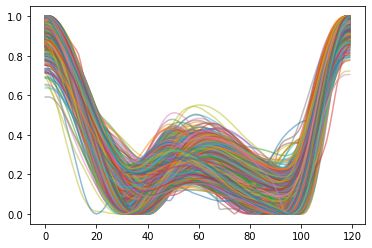

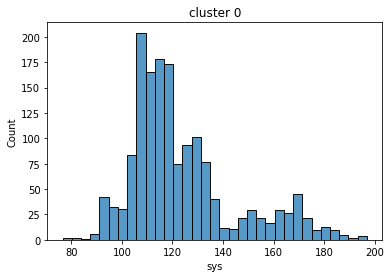

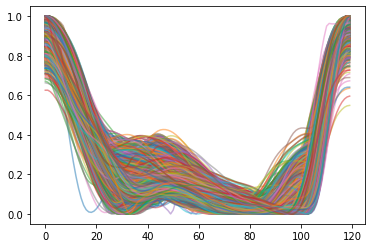

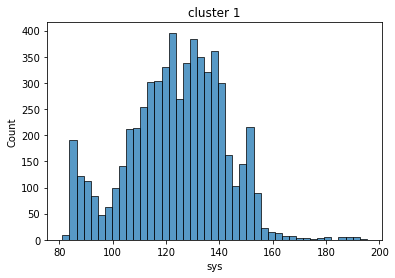

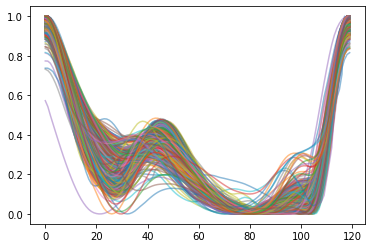

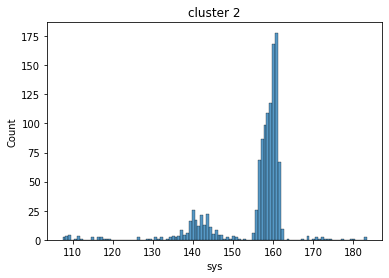

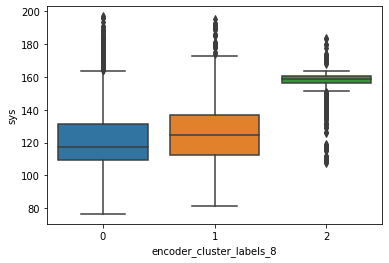

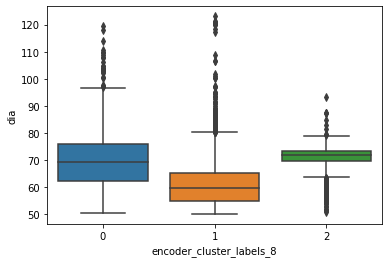

In [ ]:
for i in range(3):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == 8][encoder_cluster_labels_8 == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info_8["sys"][df_info_8 ["encoder_cluster_labels_8"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels_8",y="sys",data = df_info_8)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels_8",y="dia",data = df_info_8)

(17363, 120)